# Photometry

In order to measure Petrosian properties of galaxies, we must fist measure the photometry to construct a curve of growth. We use a set of concentric apertures with varying radii to measure the flux and construct the curve of growth. To achieve an accurate measurement, we must first identify sources in an image, mask neighboring galaxies and correct for background noise.

## Loading Example Data

The following data is a cutout of a bright galaxy in Abell-2744. The original data was aquired by the [Hubble Frontier Fields](https://frontierfields.org) team via the WFC3 instrument (`F105W` filter) and can be dirctly downloaded [here](https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0/hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz.fits). 

We first use `astropy`'s ``CCDData`` to load the example data and visualize it through `matplotlib`.

In [1]:
from astropy.nddata import CCDData

image = CCDData.read('data/abell_2744_cd_galaxy_f105w.fits.gz')

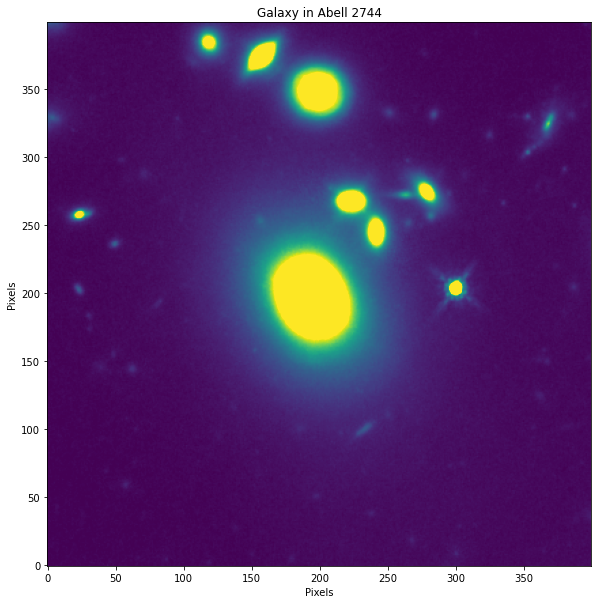

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'

vmax = image.data.std() # Use the image std as max and min of all plots 
vmin = - vmax 

plt.imshow(image.data, vmin=0, vmax=image.data.std())
plt.title("Galaxy in Abell 2744")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

### Estimate data noise at dark area

In this section we estimate the noise levels in the image. This estimate is used as a threshold for the detection and segmentation step. To estimate the background noise, we find a dark region in the image (in this case the corner of the image), and make a cutout using `Cutout2D`. We then compute the stats for that cutout region.


0.0043369904 0.003988121054135263 0.010634989477694035


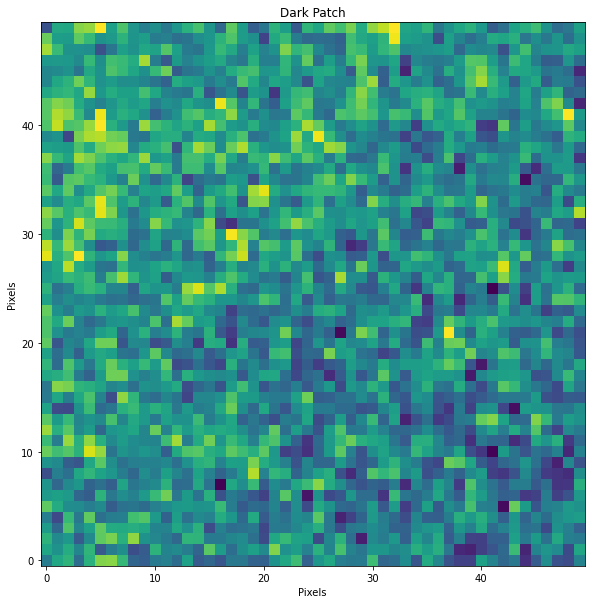

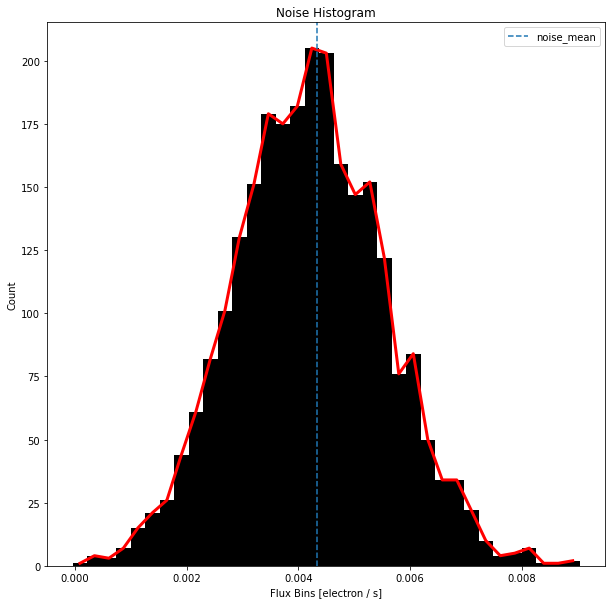

In [3]:
from astropy.nddata import Cutout2D

# Estimate data noise at dark area
# --------------------------------
noise_cutout_pos = (350, 50)
noise_cutout_size = 50 
noise_cutout = Cutout2D(image, noise_cutout_pos, noise_cutout_size)

noise_mean = noise_cutout.data.mean()
noise_sigma = noise_cutout.data.std()
noise_3_sigma = noise_sigma * 3.
noise_8_sigma = noise_sigma * 8.

print(noise_mean, noise_3_sigma, noise_8_sigma)

# Plot image and noise distribution
# ---------------------------------
plt.imshow(noise_cutout.data, vmax=noise_mean+noise_3_sigma, vmin=noise_mean-noise_3_sigma)
plt.title("Dark Patch")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

n, bins, patches = plt.hist(noise_cutout.data.flatten(), bins=35, align='left', color='black')
plt.plot(bins[:-1], n, c='r', linewidth=3)
plt.axvline(noise_mean, label="noise_mean", linestyle="--")

plt.xlabel('Flux Bins [{}]'.format(str(image.unit)))
plt.ylabel('Count')
plt.title('Noise Histogram')
plt.legend()

plt.show()

## Segmentation and Deblending

Now that we have the image loaded, we need to identfiy the sources in the image. To do this, we use `photutils` and the wrappers in `petrofit`. We first start by defining the detection threshold and making a 2D array (the same size as the image), with all values set to the threshold. We select this value to be the data standard dev or `image_std` computed in the last section.

In [4]:
import numpy as np

# Define detect threshold
nsigma = np.ones_like(image.data)
nsigma[:, :] = noise_8_sigma

Next, we define the parameters of a Gaussian kernel that is used to smooth the image before segmentation. The `kernel_size` defines the dimensions of the smoothing kernel and `fwhm` which is used to compute the `sigma` value of the Gaussian distribution. The `fwhm` is used to compute the `sigma` value as follows: 

```
sigma = fwhm * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=kernel_size, y_size=kernel_size)
```

In [5]:
# Define smoothing kernel
kernel_size = 3
fwhm = 3

We also have to define the number of pixels that make up the smallest object. `npixels` is the number of connected pixels, each greater than threshold value, that an object must have to be detected. `npixels` must be a positive integer.

In [6]:
npixels = 4**2

### Segmentation

Now we can make the segmentation map of the image using a `photutils` wrapper function and store the results in `segm`. We also use the `plot_segments` function to plot the segmentation map over the image.

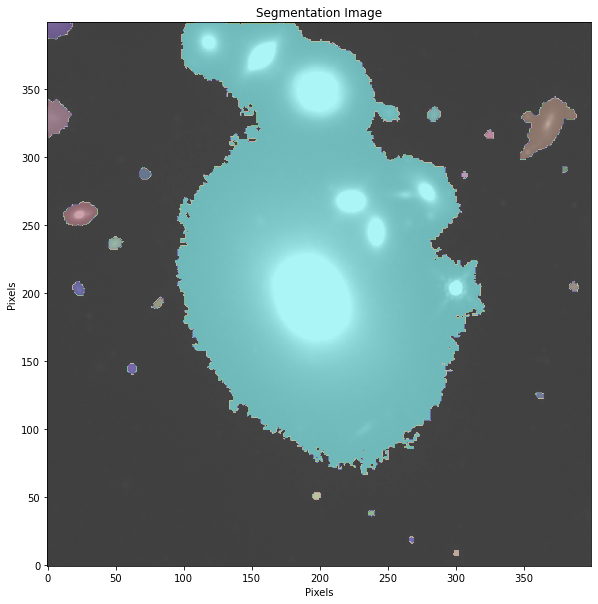

In [7]:
from petrofit.segmentation import make_segments, plot_segments

# Make segmentation map
segm = make_segments(image.data, nsigma=nsigma, 
                     kernel_size=kernel_size, 
                     fwhm=fwhm, npixels=npixels)

# Make plots 
plot_segments(segm, image=image.data, vmax=vmax, vmin=vmin)
plt.show()

### Deblending

As you can see, the segmentation resulted in the identification sources but the sources at the center  were classified as a single object because they have interconnecting pixels that are above the threshold. To further distinguish the sources, we use `photutils` to deblend the sources into individual galaxies. The `contrast` parameter is the fraction of the total (blended) source flux that a local peak must have (at any one of the multi-thresholds) to be considered as a separate object and `nlevels` is the number of multi-thresholding levels to use. We again use a wrapper for `photutils` to do this: 

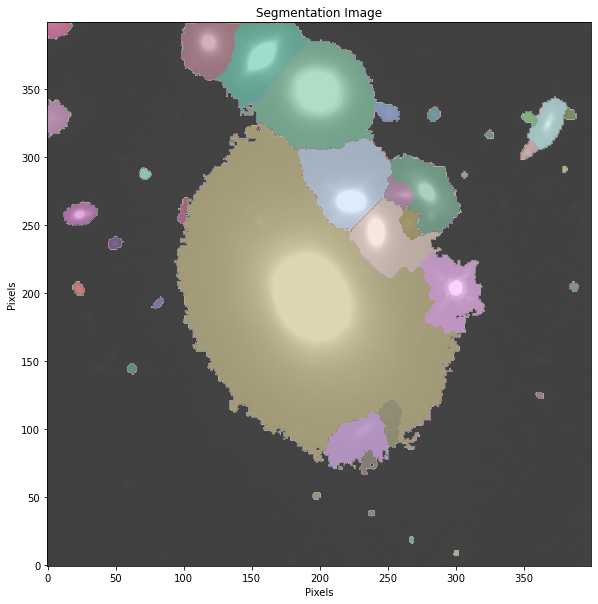

In [8]:
from petrofit.segmentation import deblend_segments

# Deblend segmentation map
segm_deblend = deblend_segments(image.data, segm, contrast=0, nlevels=50,
                                kernel_size=kernel_size, 
                                fwhm=fwhm, npixels=npixels)
# Make plots 
plot_segments(segm_deblend, image=image.data, vmax=vmax, vmin=vmin)
plt.show()

### Source Catalog

Now that we have deblended the sourecs into individual sources. The next step is to create a source catalog that contains properties like `(xcentroid, ycentroid)`, `eccentricity` and `area`. To demonstrate the useful information in the catalog, we convert the `SourceCatalog` to an `astropy.table.Table` and display the first 10 objects.

In [9]:
from photutils.segmentation import SourceCatalog 
#segm_deblend.remove_border_labels(1)

# Make catalog
cat = SourceCatalog(image.data, segm_deblend, wcs=image.wcs)

# Display source properties
print("Num of Targets:", len(cat))

# Convert to table
cat_table = cat.to_table()

cat_table[:10]

Num of Targets: 37


label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float64,float64,float64
1,300.3111014747076,8.957733205325145,"3.592749151675601,-30.394775318468113",298,302,7,11,22.0,1.3002066884255192,1.1954394910185,72.92896928748888,0.3932708655592488,0.009680937,0.020702347,0.0,0.3065427,nan,2.9920230859962698,nan
2,267.6609266662787,18.696772251857766,"3.5933800122438053,-30.394612959804533",266,269,16,21,18.0,1.338815823770431,0.9435980860927524,-78.1182121287477,0.7094055468027852,0.009548313,0.017403107,0.0,0.23814538,nan,2.2383246514730155,nan
3,238.08409785892172,38.30342199684979,"3.5939514687306926,-30.394286142171232",236,240,36,40,20.0,1.3160830369300207,1.097083917391687,21.735263634130096,0.5523719005005615,0.009238662,0.017663734,0.0,0.2633968,nan,2.6618375664393312,nan
4,197.5697198251521,51.062209393988894,"3.5947342719268875,-30.394073436784915",195,200,49,53,27.0,1.5342966800421625,1.2525893291540873,11.576258577481264,0.5774964876425596,0.0096896775,0.019357374,0.0,0.36633033,nan,4.036844715725884,nan
5,361.8704549222154,125.04174876834449,"3.5915595175034873,-30.392840653733412",359,364,123,127,24.0,1.5118081589389682,1.188072778867685,-34.625486180578605,0.6184017413798576,0.010862355,0.016101524,0.0,0.3197428,nan,2.662793396605057,nan
6,62.10086910986217,144.57752341458848,"3.5973516018950575,-30.39251461697542",59,65,141,148,43.0,1.748703072684326,1.645928883735497,-78.53671298174064,0.33777095641812893,0.009224219,0.025306074,0.0,0.6967492,nan,3.3119208425650255,nan
7,81.3936123710383,192.77146336446825,"3.5969787171133256,-30.39171142038371",77,85,189,197,42.0,2.5685002130935906,1.174078120992925,46.5552660419501,0.8894119716804528,0.009319109,0.023461932,0.0,0.5970321,nan,6.024382598248996,nan
8,22.901215834212646,203.17552689837655,"3.5981088645357167,-30.3915379067499",19,27,199,208,67.0,2.3729264639989727,1.63305574155445,-57.741529381540104,0.7255179289421537,0.010086361,0.055048924,0.0,1.6724185,nan,3.278041064316148,nan


## Photometry on Single Source

The purpose of this step is to perform aperture photometry to construct a curve of growth that we can use for the petrosian measurements. 

### Source Selection

Now that we have the location, shapes and orientations of the targets, we can perform photometry on the sources. For this example, we will focus on the largest source. We have included a helper function `order_cat` that will produce a list of indices sorted by a key (default is 'area'). We use the `order_cat` function to identify the source with the largest area and perform photometry on its cutout.

In [30]:
from petrofit.photometry import order_cat

# Sort and get the largest object in the catalog
sorted_idx_list = order_cat(cat, key='area', reverse=True)
idx = sorted_idx_list[0] # index 0 is largest 
source = cat[idx]  # get source from the catalog 

### Aperture Radii 
To construct the curve of growth, we measure the photometry using circular and/or elliptical apertures of varying radii, that are concentric and centered on the source. Before we perform the photometry, we need to provide a list of radii that will be used to construct the circular and elliptical apertures. To achieve this, we have provided a helper function that takes in the max radius in pixels (`max_pix`) and the number radii (`n`). The function will return a list of radii by dividing the range `(max_pix/n, max_pix)` into n  equally spaced integers. 

In [28]:
from petrofit.photometry import make_radius_list

r_list = make_radius_list(
    max_pix=150, # Max pixel to go up to
    n=50 # the number of radii to produce 
)

print(repr(r_list))

array([  3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,  39,
        42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,  78,
        81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114, 117,
       120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150])


### Photometry Calculation

The `source_photometry` function is used to perform photometry on a single source (`photutils.segmentation.catalog.SourceCatalog`). In this example we provide the function with the source object, the raw image (note that this is the 2D array and not `CCDData`), segmentation from the last step (`SegmentationImage`) and the list of radii we made using `make_radius_list`. Given these parameters and the options below the function performs photometry as follows:

- The positions (max value of source in pixels), elongation and position angle of the source is determined from the source object. The position will be used to center the apertures and the elongation and position angles will be used as parameters of the elliptical apertures. Each of the radii will be assigned an elliptical aperture with these parameters. 


- If `cutout_size` is defined, the code will use it to make a cutout of that size with the source centered. If the `cutout_size` is larger than the image or contains pixels outside the image, those pixels outside of the image are replaced by `np.nan`.


- Once the `cutout_size` is determined, a cutout of the error map (if provided) and image is produced. Before the raw image is cutout, sources that are not the source of interest are masked using the segmentation map. The `mask_background` option gives us the ability to also mask pixels that are considered to be background pixels because they do not belong to any source’s segmentation. All masked pixels are replaced by `np.nan` and are not counted in the returned area array.  


- If `bkg_sub` is set to true, a 2D plane is used to fit pixels that are below a specified sigma from the mean using the `petrofit.fitting.fitting.fit_plane` function. The sigma `sigma` value is used to determine noise pixels. Once the pixels above this value are masked, a 2D plane is fit to determine the background. The 2D plane model is then converted into an image and subtracted from the cutout of the target source. `sigma_type` is used to set how this `sigma` value will be used. The `sigma_type` options are `'clip'` and `'bound'`:
    - ``'clip'`` (default): Uses `astropy.stats.sigma_clipping.sigma_clip` to clip at the provided `sigma` std value. Note that `sigma` in this case is the number of stds above the mean.
    - ``'bound'`` : After computing the mean of the image, clip at `mean - sigma` and `mean + sigma`. Note that `sigma` in this case is a value and not the number of stds above the mean.


- The resulting image (after being noise subtracted if `bkg_sub` is set to true) is passed to the `petrofit.photometry.photometry_step` which constructs the apertures and performs photometry. 

After calculating the photometry at each radius, three arrays are returned:

* `flux_arr`: Photometric sum in aperture.

* `area_arr`: Exact area of aperture.

* `error_arr`: if error map is provided, error of measurements.



22


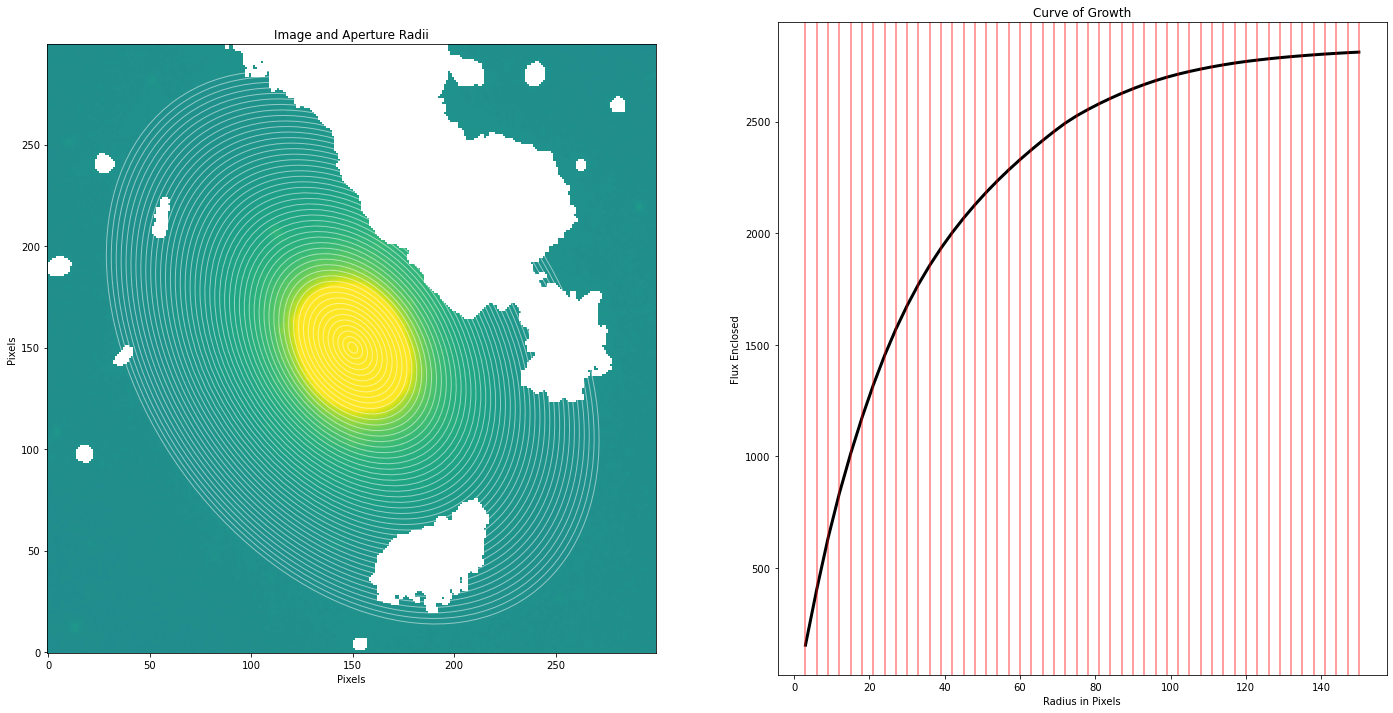

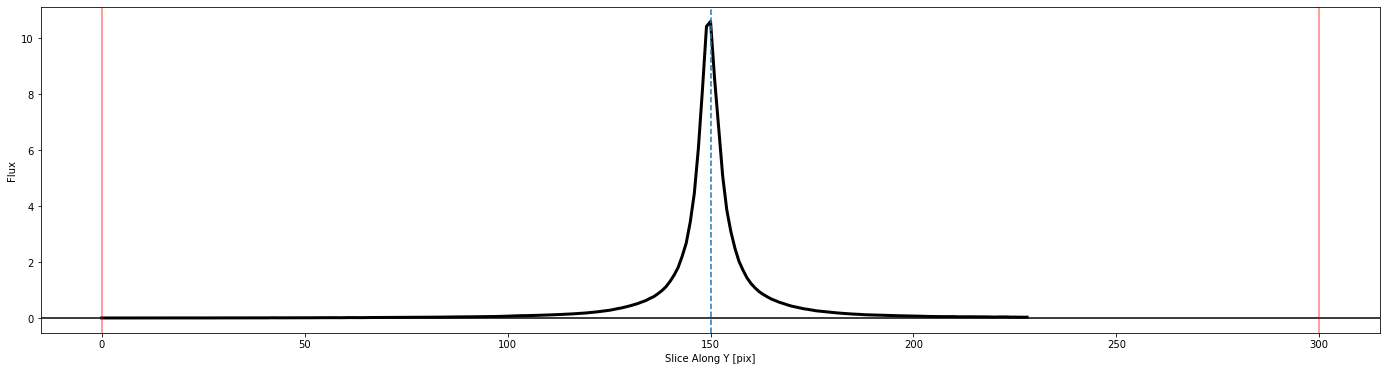

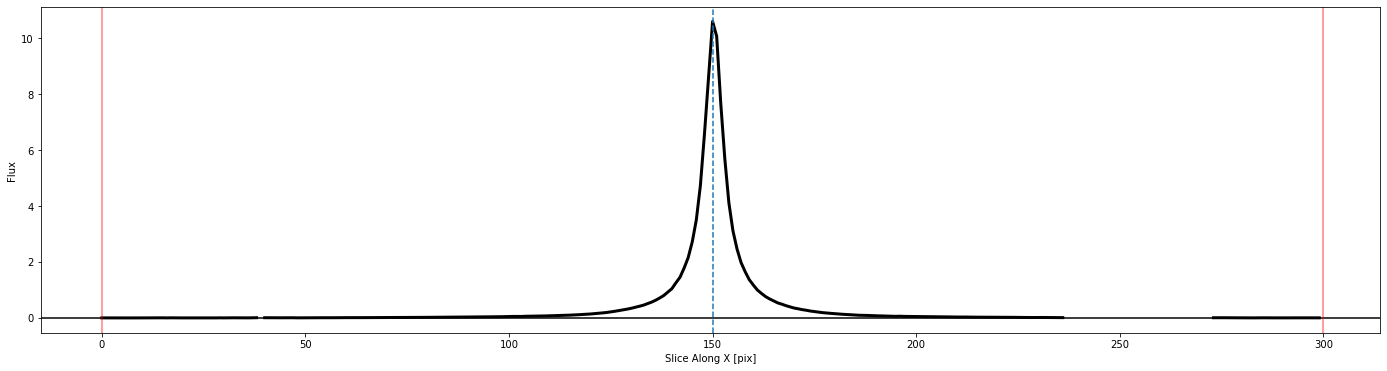

In [31]:
from petrofit.photometry import source_photometry

# Photomerty 
flux_arr, area_arr, error_arr = source_photometry(
    
    # Inputs 
    source, # Source (`photutils.segmentation.catalog.SourceCatalog`)
    image.data, # Image as 2D array 
    segm_deblend, # Deblended segmentation map of image
    r_list, # list of aperture radii  
    
    # Options 
    cutout_size=max(r_list)*2, # Cutout out size, set to double the max radius  
    bkg_sub=True, # Subtract background  
    sigma=1, sigma_type='clip', # Fit a 2D plane to pixels within 1 sigma of the mean
    plot=True, vmax=vmax, vmin=vmin, # Show plot with max and min defined above
)
plt.show()

If `source_photometry`’s `plot` option is set to True, four plots are displayed: 
- The top left plot shows the cutout with the 2D plane background subtraction and the surrounding sources masked (replaced by `np.nan`).
- The top right plot shows the curve of growth with increasing radius. The red lines represent the aperture radius.
- The bottom two plots show the source profile sliced at the center of the image in the y and x direction respectively.


# Petrosian

## Petrosian Radii

PetroFit uses the curve of growth of a galaxy’s flux to compute its Petrosian properties such as Petrosian radius and concentration index.

### Construct Petrosian from Photometry

In this section we use photometric values stored in flux, aperture area and radii arrays to construct a `Petrosian` object. The following inputs are needed as inputs:

* `r_list`: Array of radii in pixels.

* `area_list`: Array of aperture areas.

* `flux_list` : Array of photometric flux values.

This values should reprisent the curve of growth and can be computed by using the [PetroFit photometry tools](#Photometry).

The user can also specify the `eta` and `epsilon` values.

* `eta` (default=0.2) is the petrosian value which defines the petrosian radius.


* `epsilon` (default=2) is used to determine the radius of total flux.

    * `r_total_flux = r_petrosian * epsilon`

In [33]:
from petrofit.petrosian import Petrosian

p = Petrosian(r_list, area_arr, flux_arr)

### Petrosian radius

The Petrosian radius is defined as the radius at which the Petrosian profile reaches the Eta (`eta`, default=0.2) value.

In [34]:
p.r_petrosian # in pixels

61.752950590118026

### Petrosian total flux radius

The Petrosian flux or total flux radius is the radius which ideally encloses all the flux of the galaxy. The Petrosian total flux radius is estimated by multiplying `r_petrosian` with `epsilon` (default=2). 

`r_total_flux = r_petrosian * epsilon`

We can use the `r_total_flux_arcsec` function, by passing it a WCS object, to compute the total flux radius in arcsec.

In [15]:
p.r_total_flux # pixels

123.50590118023605

In [16]:
p.r_total_flux_arcsec(image.wcs) # arcsec

7.410352696979863

### Petrosian half light radius

The half light radius contains half of the galaxy total flux. To compute the half light radius, we find the total flux (flux at `r_total_flux`) and divide it by half to find the “half flux” or “half light”. We then find the pixel closest to the half light value and define it as the half light radius. Please note that interpolation is used between the inputted flux radii to find the radius that best matches the half light flux.   

We can use the `r_half_light_arcsec` function, by passing it a WCS object, to compute the half light radius in arcsec.


In [17]:
p.r_half_light # pixels

22.525505101020205

In [18]:
p.r_half_light_arcsec(image.wcs) # arcsec

1.3515300554957637

### Concentration Index

The concentration index is the ratio two aperture radii that contain a fraction (percent) of the total flux. It is computed as follows  

`concentration_index = 5 * np.log10( r(fraction_2) / r(fraction_1) )`

The default is set to `fraction_1 = 0.2` and `fraction_2 = 0.8`. The `concentration_index` function returns the `r_fraction_1`, `r_fraction_2` and `concentration_index`.

In these examples, we comput the default `C2080` and `C5090` concentration indices for the input galaxy:

In [19]:
r_20, r_80, c2080 = p.concentration_index()  # defualt c2080

r_20, r_80, c2080 # Radii in pixels

(7.910782156431286, 53.19583916783357, 4.138291195164365)

In [35]:
r_50, r_90, c5090 = p.concentration_index(
    fraction_1=0.5, 
    fraction_2=0.9
)

r_50, r_90, c5090 # Radii in pixels

(22.525505101020205, 72.48609721944389, 2.537900895119716)

### Petrosian Plot

The  Petrosian plot shows the Petrosian profile, the `eta` valued to define the Petrosian radius and the  Petrosian radius. The blue points are the data points and the orange curve is the interpolated values.

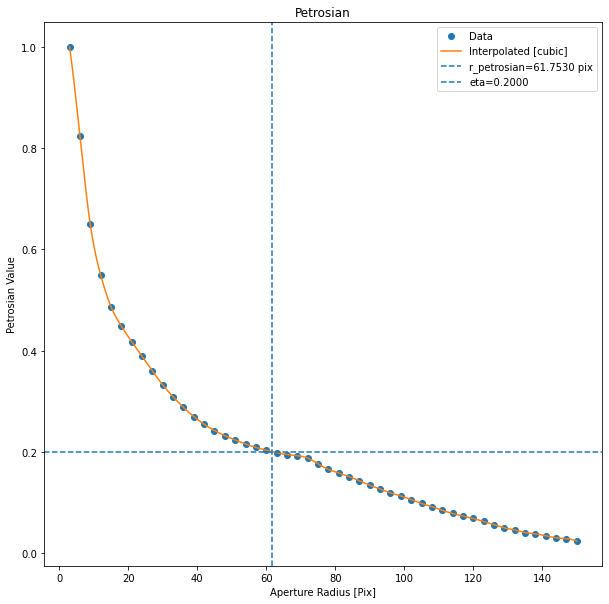

In [36]:
# Plot the Petrosian profile
p.plot()
plt.show()

We can overplot the half light radius and total flux radius by setting `plot_r=True`. We can also overplot a normalized flux curve of growth by setting `plot_normalized_flux=True`.

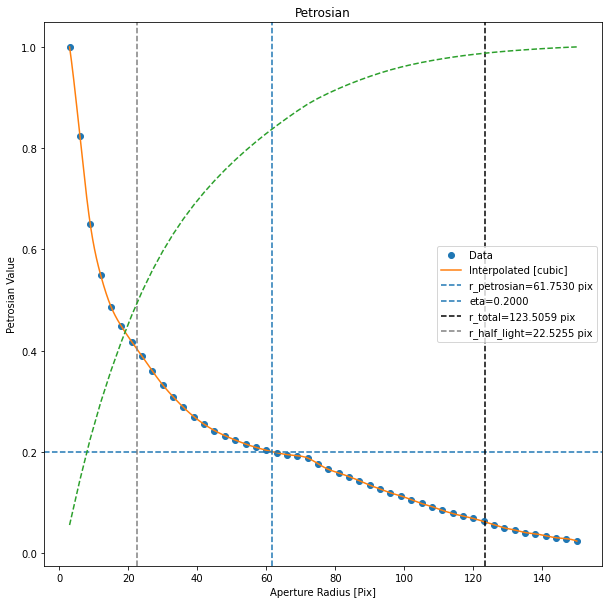

In [37]:
# Plot with radii and overplot normalized flux curve of growth
p.plot(plot_r=True, plot_normalized_flux=True)
plt.show()

### Change eta and epsilon

We can change the petrosian `eta` and `epsilon` values after the `Petrosian` object has been initiated by setting their respective attributes. After setting the attributes, all other calculations and plots will use the new values.

In this example we copy the `Petrosian` object and change the `eta` and `epsilon` values to see how the radii change. Note how `r_half_light` and `r_total_flux` changed. Since `epsilon = 1`, `r_total_flux = r_petrosian` 


eta = 0.3
epsilon = 1
r_half_light (old vs new) = 22.53 vs 13.12
r_total_flux (old vs new) = 123.51 vs 34.20


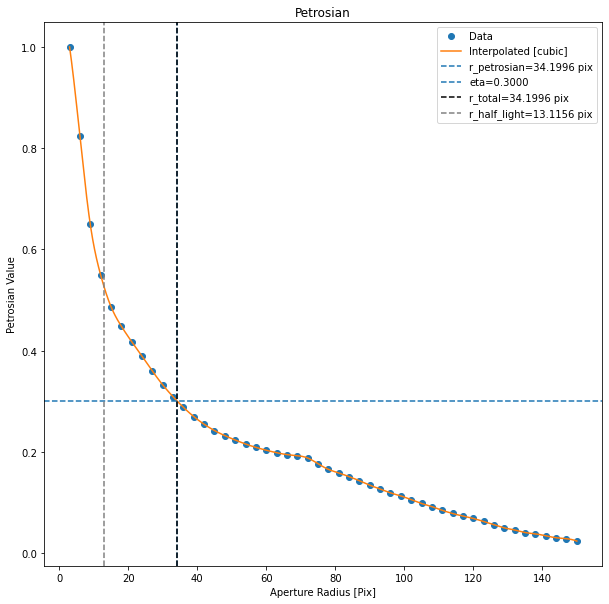

In [49]:
from copy import copy

p_copy = copy(p)
p_copy.eta = 0.3
p_copy.epsilon = 1

print('eta =', p_copy.eta)
print('epsilon =', p_copy.epsilon)
print('r_half_light (old vs new) = {:0.2f} vs {:0.2f}'.format(p.r_half_light, p_copy.r_half_light))
print('r_total_flux (old vs new) = {:0.2f} vs {:0.2f}'.format(p.r_total_flux, p_copy.r_total_flux))
p_copy.plot(plot_r=True)